In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
import inspect, random, os
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from multiprocessing import Pool
from rdkit.Chem import Draw, PandasTools
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from torch_geometric.nn.aggr import AttentionalAggregation
import torch
from modules.som_dataset import CustomDataset
# from models.som_models import GNNSOM
from modules.som_models import GNNSOM
from utils import validation
from tabulate import tabulate
from tqdm import tqdm
import numpy as np
from PIL import Image
from scipy import stats
from collections import defaultdict
from glob import glob
import json
import warnings
warnings.filterwarnings('ignore', '.*Sparse CSR tensor support is in beta state.*')
warnings.filterwarnings('ignore', '')

In [2]:
import json

def save_json(json_path, dict_file):
    with open(json_path, 'w') as file:
        json.dump(dict_file, file)

def load_json(json_path):
    with open(json_path, "r") as st_json:
        json_obj = json.load(st_json)
    return json_obj   

In [3]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2., n - 1)
            
    lower_bound = max(m - h, 0)
    mean = max(m, 0)
    upper_bound = max(m + h, 0)
    return lower_bound, mean, upper_bound

In [4]:
def to_csv(path, table_data, headers):
    score_logs = tabulate(table_data, headers, tablefmt="tsv")
    text_file=open(path,"w")
    text_file.write(score_logs)
    text_file.close()
    df = pd.read_csv(path, sep='\t')
    df.to_csv(path, index=None)

def get_logs(scores, cyp_list, args):        
    logs = ''
    table_data1 = []
    table_data2 = []
    table_data3 = []
    table_data4 = []
    for cyp in cyp_list:        
        headers1 = ['CYP', 
                   'auc_subs', 'apc_subs', 'f1s_subs', 'rec_subs', 'prc_subs', 'n_subs',                    
                   ]
        
        headers2 = ['CYP',
                    'jac_bond_som', 'f1s_bond_som', 'apc_bond_som', 'n_bond_som',
                    'jac_atom_spn', 'f1s_atom_spn', 'apc_atom_spn', 'n_atom_spn',                    
                    'jac_som', 'f1s_som', 'apc_som', 'n_som',
                    ]   
        headers3 = ['CYP', 
                    'jac_oxc', 'f1s_oxc', 'apc_oxc', 'n_oxc',
                    'jac_oxi', 'f1s_oxi', 'apc_oxi', 'n_oxi',
                    'jac_epo', 'f1s_epo', 'apc_epo', 'n_epo',
                    'jac_sut', 'f1s_sut', 'apc_sut', 'n_sut',
                    'jac_dhy', 'f1s_dhy', 'apc_dhy', 'n_dhy',
                    'jac_hys', 'f1s_hys', 'apc_hys', 'n_hys',
                    'jac_rdc', 'f1s_rdc', 'apc_rdc', 'n_rdc',

                    ]        
        headers4 = ['CYP',
                    'n_subs', 'n_bond_som', 'n_atom_spn', 'n_som', 'n_oxc', 'n_oxi', 'n_epo', 'n_sut', 'n_dhy', 'n_hys', 'n_rdc',
                    ]          
        row1, row2, row3, row4 = [cyp], [cyp], [cyp], [cyp]
        for header in headers1[1:]:
            if 'loss' in header or header[:2] == 'n_':
                row1.append(scores[cyp][header])
            else:
                row1.append(scores[cyp][args.th][header])
                
                
        for header in headers2[1:]:
            if 'loss' in header or header[:2] == 'n_':
                row2.append(scores[cyp][header])
            else:
                row2.append(scores[cyp][args.th][header])
        
        for header in headers3[1:]:
            if 'loss' in header or header[:2] == 'n_':
                row3.append(scores[cyp][header])
            else:
                row3.append(scores[cyp][args.th][header])

        for header in headers4[1:]:
            if 'loss' in header or header[:2] == 'n_':
                row4.append(scores[cyp][header])
            else:
                row4.append(scores[cyp][args.th][header])

        table_data1.append(row1)
        table_data2.append(row2)
        table_data3.append(row3)        
        table_data4.append(row4)        

    # logs += (tabulate(table_data1, headers1, tablefmt="grid", floatfmt=".4f") + '\n')
    logs += (tabulate(table_data2, headers2, tablefmt="grid", floatfmt=".4f") + '\n')
    # logs += (tabulate(table_data3, headers3, tablefmt="grid", floatfmt=".4f") + '\n')
    # logs += tabulate(table_data4, headers4, tablefmt="grid", floatfmt=".4f")

    return logs

In [5]:
def CYP_REACTION(x):
    cyp_col = ['BOM_1A2', 'BOM_2A6', 'BOM_2B6', 'BOM_2C8', 'BOM_2C9', 'BOM_2C19', 'BOM_2D6', 'BOM_2E1', 'BOM_3A4']
    cyp_reactions = x[cyp_col].tolist()
    cyp_reactions = [i for i in cyp_reactions if i] 
    return '\n'.join( cyp_reactions )

In [6]:
metrics = [
    'auc_subs', 'apc_subs', 'f1s_subs', 'rec_subs', 'prc_subs',
    'jac_bond_som', 'f1s_bond_som', 'prc_bond_som', 'rec_bond_som', 'auc_bond_som', 'apc_bond_som',
    'jac_atom_spn', 'f1s_atom_spn', 'prc_atom_spn', 'rec_atom_spn', 'auc_atom_spn', 'apc_atom_spn',
    
    'jac_oxc', 'f1s_oxc', 'prc_oxc', 'rec_oxc', 'auc_oxc', 'apc_oxc',
    'jac_oxi', 'f1s_oxi', 'prc_oxi', 'rec_oxi', 'auc_oxi', 'apc_oxi',
    'jac_epo', 'f1s_epo', 'prc_epo', 'rec_epo', 'auc_epo', 'apc_epo',
    'jac_sut', 'f1s_sut', 'prc_sut', 'rec_sut', 'auc_sut', 'apc_sut',
    'jac_dhy', 'f1s_dhy', 'prc_dhy', 'rec_dhy', 'auc_dhy', 'apc_dhy',
    'jac_hys', 'f1s_hys', 'prc_hys', 'rec_hys', 'auc_hys', 'apc_hys',
    'jac_rdc', 'f1s_rdc', 'prc_rdc', 'rec_rdc', 'auc_rdc', 'apc_rdc',

    'jac_som', 'f1s_som', 'prc_som', 'rec_som', 'auc_som', 'apc_som',
    ]

In [7]:
cyp_list = [f'BOM_{i}' for i in  '1A2 2A6 2B6 2C8 2C9 2C19 2D6 2E1 3A4'.split()] + ['CYP_REACTION']

In [8]:
class CONFIG:
    substrate_loss_weight = 0.33    
    bond_loss_weight = 0.33
    atom_loss_weight = 0.33
    som_type_loss_weight = 0.33
    class_type = 2    
    th = 0.1    
    substrate_th = 0.5
    adjust_substrate = False
    average = 'binary'    
    equivalent_bonds_mean = True
    train_only_spn_H_atom = False    
    device = 'cuda:0'
    test_only_reaction_mol = False
    drop_node_p = 0.0
    mask_node_p = 0.0
    filt_som = 0
    equivalent_mean = False
    reduction = 'sum'
    metric_mode = 'atom'
    n_classes = 5
args = CONFIG()



In [9]:
model = GNNSOM(
            num_layers=2,
            gnn_num_layers = 8,
            pooling='sum',
            dropout=0.1, 
            cyp_list=cyp_list, 
            use_face = True, 
            node_attn = True,
            face_attn = True,            
            n_classes=args.n_classes,
            ).to('cuda:0')

In [10]:
df = PandasTools.LoadSDF('data/train_nonreact_0710.sdf')
df['CYP_REACTION'] = df.apply(CYP_REACTION, axis=1)
df['POS_ID'] = 'TRAIN' + df.index.astype(str).str.zfill(4)
df['is_react'] = (df['CYP_REACTION'] == '').astype(int).astype(str)

train_df, valid_df = train_test_split(df, stratify=df['is_react'], random_state=1, test_size=0.2)
train_df, valid_df = train_df.reset_index(drop=True), valid_df.reset_index(drop=True) 
# train_dataset = CustomDataset(df=df, class_type=2, cyp_list=cyp_list, args=args, add_H=True)
# train_loader = DataLoader(train_dataset, num_workers=2, batch_size=16, shuffle=False)

In [11]:
# for seed in range(30):
#     t_df, v_df = train_test_split(df, test_size=0.2, stratify=(df['CYP_REACTION'] == ''),  random_state=seed)
#     t_df, v_df = t_df.reset_index(drop=True), v_df.reset_index(drop=True)

#     print(seed, t_df[t_df['BOM_1A2'] != ''].shape[0], v_df[v_df['BOM_1A2'] != ''].shape[0])

In [12]:
for cyp in cyp_list:
    print(cyp, df[df[cyp] != ''].shape[0])

BOM_1A2 358
BOM_2A6 132
BOM_2B6 184
BOM_2C8 195
BOM_2C9 297
BOM_2C19 290
BOM_2D6 359
BOM_2E1 160
BOM_3A4 661
CYP_REACTION 940


In [13]:
test_df = PandasTools.LoadSDF('data/test_0710.sdf')
test_df['CYP_REACTION'] = test_df.apply(CYP_REACTION, axis=1)
test_df['POS_ID'] = 'TEST' + test_df.index.astype(str).str.zfill(4)

test_dataset = CustomDataset(df=test_df, cyp_list=cyp_list, args=args)
test_loader = DataLoader(test_dataset, num_workers=2, batch_size=8, shuffle=False)

loss_fn_ce, loss_fn_bce = torch.nn.CrossEntropyLoss(), torch.nn.BCEWithLogitsLoss()

Processing...
Done!


In [14]:
loss_fn_bce = torch.nn.BCEWithLogitsLoss()
loss_fn_ce = torch.nn.CrossEntropyLoss()

### 신뢰구간별

In [15]:
def cal_scores(validator, args):
    scores = {}

    if args.adjust_substrate:
        validator.adjust_substrate(args.substrate_th)

    tasks = ['subs', 'som', 'bond_som', 'atom_som',  'atom_spn','oxc', 'oxi', 'epo', 'sut', 'dhy', 'hys', 'rdc']
    metrics = ['jac', 'f1s', 'prc', 'rec', 'auc', 'apc']

    if args.equivalent_mean:
        validator.unbatch()
        validator.eq_mean()

    for cyp in model.cyp_list:
        scores[cyp] = {}        
        
        for task in tasks:
            y_true, y_prob = validator.get_probs(task, cyp)
            scores[cyp][f'n_{task}'] = f'{int(sum(y_true))} / {len(y_true)}'

            if task == 'subs':
                task_scores = validator.get_scores(task=task, cyp=cyp, average=args.average, th=args.substrate_th)
            else:
                task_scores = validator.get_scores(task=task, cyp=cyp, average=args.average, th=args.th)

            for mname, tscore in zip(metrics, task_scores):
                scores[cyp][f'{mname}_{task}'] = tscore
    scores['CYP_REACTION_max'] = {}  
    for task in tasks:
        y_true_cyp_max = []
        y_prob_cyp_max = []
        for cyp in ['BOM_1A2','BOM_2A6','BOM_2B6','BOM_2C8','BOM_2C9','BOM_2C19','BOM_2D6','BOM_2E1','BOM_3A4']:
            y_true, y_prob = validator.get_probs(task, cyp)
            y_true_cyp_max.append(y_true)
            y_prob_cyp_max.append(y_prob)
        y_true_cyp_max = np.stack(y_true_cyp_max).max(0).astype(int)
        y_prob_cyp_max = np.stack(y_prob_cyp_max).max(0)
        if task == 'subs':
            task_scores = validator.get_scores(task=task, cyp=cyp, average=args.average, th=args.substrate_th, y_true=y_true_cyp_max, y_prob=y_prob_cyp_max)
        else:
            task_scores = validator.get_scores(task=task, cyp=cyp, average=args.average, th=args.th, y_true=y_true_cyp_max, y_prob=y_prob_cyp_max)
        for mname, tscore in zip(metrics, task_scores):
            scores['CYP_REACTION_max'][f'{mname}_{task}'] = tscore              
    return scores

In [16]:
args.metric_mode = 'bond'

In [17]:
for seed in tqdm(range(30)):        
    args.ckpt = f'ckpt/{seed}.pt'
    args.ckpt = f'ckpt/1.pt'    
    model.load_state_dict(torch.load(args.ckpt, 'cpu'))
    model = model.eval()
    
    args.add_H = True

    seed_df = []
    
    test_scores = validation(model, test_loader, loss_fn_ce, loss_fn_bce, args)
    validator = test_scores['validator'] 
    for th in [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]:
        args.th = th
        scores = cal_scores(validator, args)
        for cyp in cyp_list + ['CYP_REACTION_max']:
            for metric in metrics:
                seed_df.append({'cyp' : cyp, 'seed' : seed, 'metric' : metric, 'score' : scores[cyp][metric], 'threshold' : th})

    seed_df = pd.DataFrame(seed_df)
    seed_df.to_csv(f'infer/seed/{seed}.csv', index=None)
    break

  0%|          | 0/30 [00:15<?, ?it/s]


In [32]:
test_scores['BOM_1A2'][0.1]['jac_bond_som']

0.1826625386996904

In [18]:
seed_df_dict = {}
for seed in range(30):
    seed_df = pd.read_csv(f'infer/seed/{seed}.csv', index_col=None)
    seed_df_dict[seed] = seed_df
    break
    

In [19]:
# # 시드 30개의 신뢰구간 성능
# th = 0.05
# args.th = th

# ci_scores = scores.copy()

# for cyp in tqdm(cyp_list):
#     ci_scores[cyp][th] = {}
#     for metric in metrics:
#         score_value = []
#         for seed in seed_df_dict.keys():
#             score_value.append(seed_df_dict[seed].query('cyp==@cyp').query('metric==@metric').query('threshold==@th').score.item())
#         s, m, l = confidence_interval(score_value)
#         ci_scores[cyp][th][metric] = m
#         # ci_scores[cyp][th][metric] =  f'{m:.4f}({s:.2f}-{l:.2f})'
# print(get_logs(ci_scores, cyp_list, args))

In [20]:
# seed 평균 저장 (시각화 용)

for th in [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]:
    score_df = []

    for cyp in cyp_list + ['CYP_REACTION_max']:
        for metric in metrics:
            
            score_value = []
            for seed in seed_df_dict.keys():
                score_value.append(seed_df_dict[seed].query('cyp==@cyp').query('metric==@metric').query('threshold==@th').score.item())
            _,score,_ = confidence_interval(score_value)
            score_df.append({'cyp' : cyp, 'metric' : metric, 'score' : score})
    score_df = pd.DataFrame(score_df)
    score_df.to_csv( f'scores/GNN-CYPSOM_{th}.csv', index=None)

In [21]:
def save_performance(metrics, mtype_name, root):
    images = [Image.open(f'{root}/performance_{metric}.png') for metric in metrics]

    widths, heights = zip(*(i.size for i in images))

    max_width = max(widths)
    total_height = sum(heights)

    # 이미지 사이의 여백 (픽셀 단위)
    padding = 10

    # 새로운 이미지 캔버스 생성
    new_im = Image.new('RGB', (max_width, total_height + padding * (len(images) - 1)), (255, 255, 255))

    # 이미지를 세로로 합치기
    y_offset = 0
    for im in images:
        new_im.paste(im, (0, y_offset))
        y_offset += im.size[1] + padding

    # 합친 이미지 저장
    new_im.save(f'{root}/performance_{mtype_name}.png')

    for metric in metrics:
        os.remove(f'{root}/performance_{metric}.png')    

In [22]:
cyp_list = ['BOM_1A2', 'BOM_2A6', 'BOM_2B6', 'BOM_2C8', 'BOM_2C9', 'BOM_2C19', 'BOM_2D6', 'BOM_2E1', 'BOM_3A4'] 

In [23]:
metrics_name = ['Substrate', 'Bond-SOM', 'SPN-Oxidation', 'SOM', 'OxidativeCleavage', 'Oxidation', 'Epoxidation', 'Substitution', 'Dehydrogenation', 'Hydrolysis', 'Reduction']

metrics_types = [
    ['auc_subs', 'apc_subs', 'f1s_subs'],
    ['jac_bond_som', 'f1s_bond_som', 'prc_bond_som', 'rec_bond_som', 'auc_bond_som', 'apc_bond_som'],
    ['jac_atom_spn', 'f1s_atom_spn', 'prc_atom_spn', 'rec_atom_spn', 'auc_atom_spn', 'apc_atom_spn'],

    ['jac_som', 'f1s_som', 'prc_som', 'rec_som', 'auc_som', 'apc_som'],

    ['jac_oxc', 'f1s_oxc', 'prc_oxc', 'rec_oxc', 'auc_oxc', 'apc_oxc'],
    ['jac_oxi', 'f1s_oxi', 'prc_oxi', 'rec_oxi', 'auc_oxi', 'apc_oxi'],
    ['jac_epo', 'f1s_epo', 'prc_epo', 'rec_epo', 'auc_epo', 'apc_epo'],
    ['jac_sut', 'f1s_sut', 'prc_sut', 'rec_sut', 'auc_sut', 'apc_sut'],
    ['jac_dhy', 'f1s_dhy', 'prc_dhy', 'rec_dhy', 'auc_dhy', 'apc_dhy'],
    ['jac_hys', 'f1s_hys', 'prc_hys', 'rec_hys', 'auc_hys', 'apc_hys'],
    ['jac_rdc', 'f1s_rdc', 'prc_rdc', 'rec_rdc', 'auc_rdc', 'apc_rdc']]


plot_name_types = [
    ['AUROC Substrate', 'AUPRC Substrate', 'F1-Score Substrate'],    
    ['Jaccard Score Bond', 'F1-Score Bond', 'Precision Bond', 'Recall Bond', 'AUROC Bond', 'AUPRC Bond'],
    ['Jaccard Score SPN-Oxidation', 'F1-Score SPN-Oxidation', 'Precision SPN-Oxidation', 'Recall SPN-Oxidation', 'AUROC SPN-Oxidation', 'AUPRC SPN-Oxidation'],

    ['Jaccard Score SOM', 'F1-Score SOM', 'Precision som', 'Recall som', 'AUROC som', 'AUPRC SOM'],

    ['Jaccard Score OxidativeCleavage', 'F1-Score OxidativeCleavage', 'Precision OxidativeCleavage', 'Recall OxidativeCleavage', 'AUROC OxidativeCleavage', 'AUPRC OxidativeCleavage'],    
    ['Jaccard Score Oxidation', 'F1-Score Oxidation', 'Precision Oxidation', 'Recall Oxidation', 'AUROC Oxidation', 'AUPRC Oxidation'],
    ['Jaccard Score EpOxidation', 'F1-Score EpOxidation', 'Precision EpOxidation', 'Recall EpOxidation', 'AUROC EpOxidation', 'AUPRC EpOxidation'],    
    ['Jaccard Score Substitution', 'F1-Score Substitution', 'Precision Substitution', 'Recall Substitution', 'AUROC Substitution', 'AUPRC Substitution'],    
    ['Jaccard Score Dehydrogenation', 'F1-Score Dehydrogenation', 'Precision Dehydrogenation', 'Recall Dehydrogenation', 'AUROC Dehydrogenation', 'AUPRC Dehydrogenation'],    
    ['Jaccard Score Hydrolysis', 'F1-Score Hydrolysis', 'Precision Hydrolysis', 'Recall Hydrolysis', 'AUROC Hydrolysis', 'AUPRC Hydrolysis'],        
    ['Jaccard Score Reduction', 'F1-Score Reduction', 'Precision Reduction', 'Recall Reduction', 'AUROC Reduction', 'AUPRC Reduction'],
    
    ]

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

scores_cyproduct = pd.read_csv(f'scores/CYProduct.csv', index_col=None)
scores_DCyPre = pd.read_csv(f'scores/DCyPre.csv', index_col=None)
scores_df = [pd.read_csv(f'scores/GNN-CYPSOM_{i}.csv', index_col=None) for i in [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]]


root = f'plot_score/versus_other_research'
select_th=True
if not select_th:
    models = ['CYProduct', 'DCyPre', 'GNN-CYPSOM_0.01', 'GNN-CYPSOM_0.1', 'GNN-CYPSOM_0.15', 'GNN-CYPSOM_0.2', 'GNN-CYPSOM_0.3', 'GNN-CYPSOM_0.4']
    models = ['CYProduct', 'DCyPre', 'GNN-CYPSOM_0.01', 'GNN-CYPSOM_0.05', 'GNN-CYPSOM_0.1',  'GNN-CYPSOM_0.2', 'GNN-CYPSOM_0.3', 'GNN-CYPSOM_0.4', 'GNN-CYPSOM_0.5']
# models = ['CYProduct', 'GNN-CYPSOM_0.15',]
else:
    models = ['CYProduct', 'DCyPre', 'GNN-CYPSOM',]
    # models = ['DCyPre', 'GNN-CYPSOM',]

for m_name, metrics, plot_name_metrics in zip(metrics_name, metrics_types, plot_name_types):
    metrics = [i for i in metrics if ('rec' not in i) and ('prc' not in i) and ('auc' not in i)]
    plot_name_metrics = [i for i in plot_name_metrics if ('Recall' not in i) and ('Precision' not in i) and ('AUROC' not in i)]
    pallete = sns.color_palette("Paired")

    for idx, metric in enumerate(metrics):
        data = pd.DataFrame(columns=['CYP', 'Model', metric])
        
        for model in models:
            for cyp in cyp_list:
                if not select_th:
                    scores = pd.read_csv(f'scores/{model}.csv')
                    if model == 'DCyPre':
                        try:
                            score = scores.query('cyp==@cyp').query('metric==@metric')['score'].item()
                        except:
                            score = 0
                            continue
                    score = scores.query('cyp==@cyp').query('metric==@metric')['score'].item()
                else:
                    if model == 'CYProduct':
                        score = scores_cyproduct.query('cyp==@cyp').query('metric==@metric')['score'].item()
                    elif model == 'DCyPre':
                        try:
                            score = scores_DCyPre.query('cyp==@cyp').query('metric==@metric')['score'].item()
                        except:
                            score = 0
                    else:                        
                        score = max([i.query('cyp==@cyp').query('metric==@metric')['score'].item() for i in scores_df])
  

                data = pd.concat( [data, pd.DataFrame({'CYP': [cyp.replace('BOM_', '')], 'Model': [model], metric: [score]})]
                                    , ignore_index=True)
        
        plt.figure(figsize=(15, 2.5))
        sns.set_style('whitegrid')
        
        ax = sns.barplot(x='CYP', y=metric, hue='Model', data=data, palette=pallete, width=0.7)
        
        ax.set_xlabel('')
        ax.set_ylabel(metric)
            
        # ax.set_ylim(0, 1)  # y축 범위를 0부터 1까지로 고정
        maxvalue = round(data[metric].max(), 1)
        ax.set_ylim(0, maxvalue+0.05)  # y축 범위를 0부터 1까지로 고정
        
        # if 'ROC' in plot_name_metrics[idx]:
        #     ax.set_ylim(0, 1)  # y축 범위를 0부터 1까지로 고정
        # else:
        #     ax.set_ylim(0, 0.5)  # y축 범위를 0부터 1까지로 고정
            
        ax.set_title(f'{plot_name_metrics[idx]}', fontsize=12, fontweight='bold', pad=10)
        
        ax.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
                
        plt.tight_layout()
        plt.savefig(f'{root}/performance_{metric}.png', bbox_inches='tight')
        plt.close()

    save_performance(metrics, m_name, root)

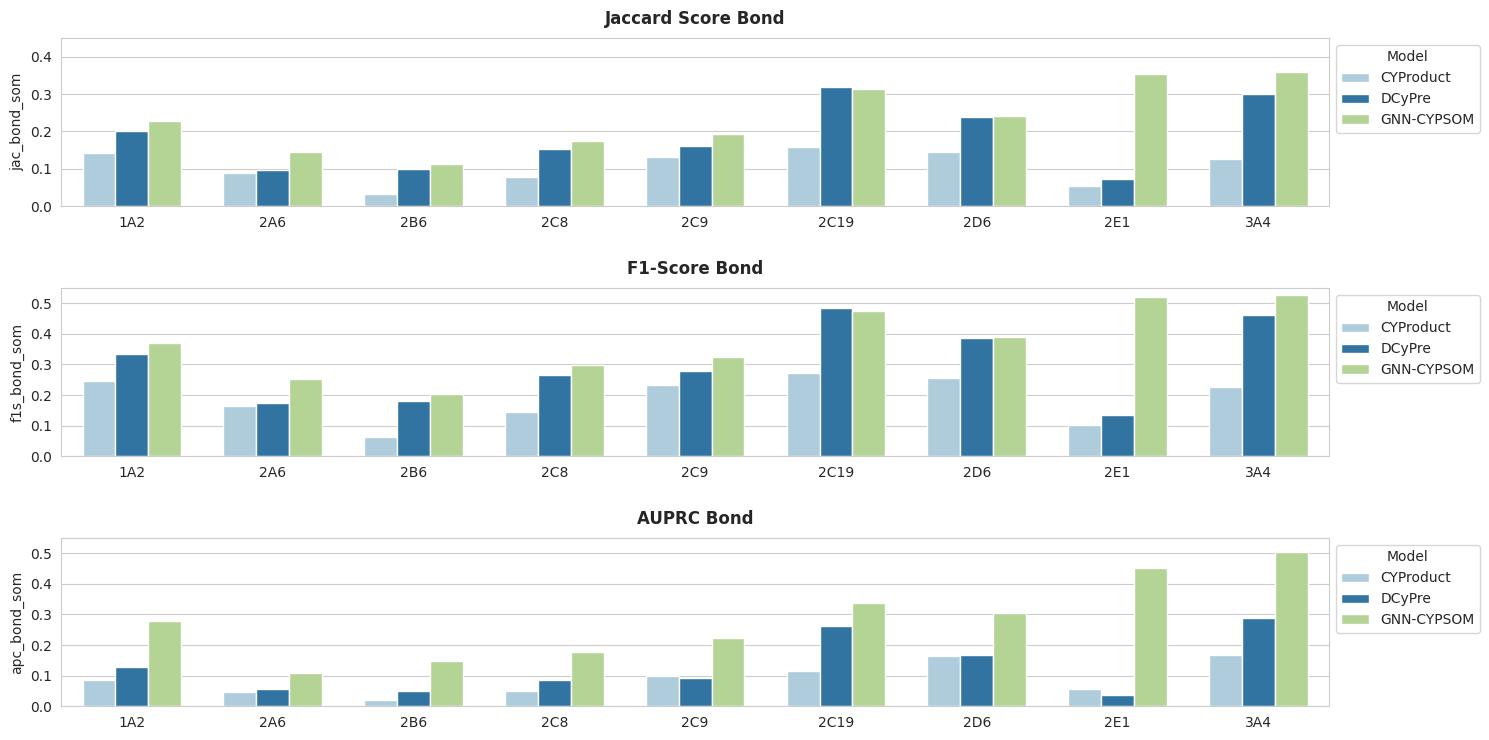

In [25]:
Image.open('plot_score/versus_other_research/performance_Bond-SOM.png')

In [26]:
def save_performance(metrics, mtype_name, root):
    images = [Image.open(f'{root}/performance_{metric}.png') for metric in metrics]

    widths, heights = zip(*(i.size for i in images))

    max_width = max(widths)
    total_height = sum(heights)

    # 이미지 사이의 여백 (픽셀 단위)
    padding = 10

    # 새로운 이미지 캔버스 생성
    new_im = Image.new('RGB', (max_width, total_height + padding * (len(images) - 1)), (255, 255, 255))

    # 이미지를 세로로 합치기
    y_offset = 0
    for im in images:
        new_im.paste(im, (0, y_offset))
        y_offset += im.size[1] + padding

    # 합친 이미지 저장
    new_im.save(f'{root}/performance_{mtype_name}.png')

    for metric in metrics:
        os.remove(f'{root}/performance_{metric}.png')    

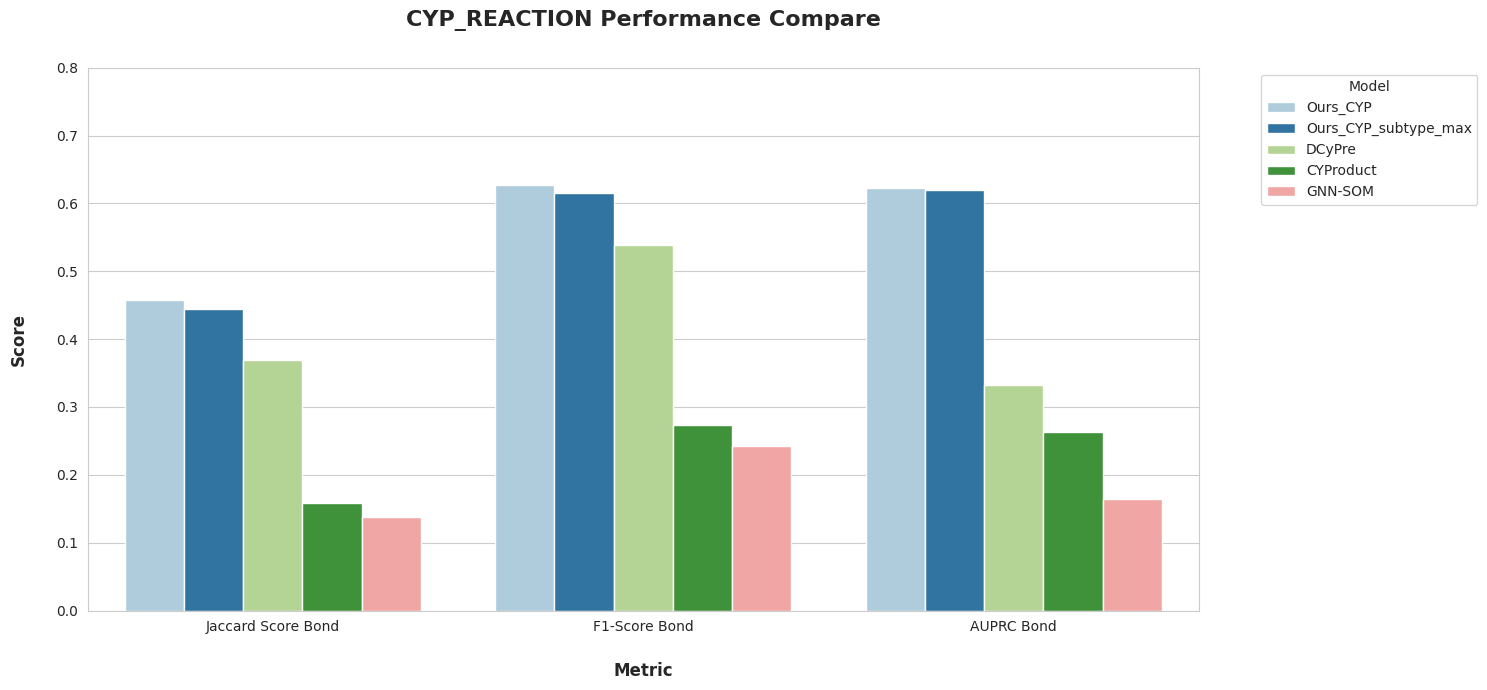

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

metrics_name = ['Bond-SOM',]
metrics_types = ['jac_bond_som', 'f1s_bond_som', 'apc_bond_som']
plot_name_types = ['Jaccard Score Bond', 'F1-Score Bond', 'AUPRC Bond']

gnn_som = pd.read_csv('scores/GNN-SOM.csv')
scores_cyproduct = pd.read_csv(f'scores/CYProduct.csv', index_col=None)
scores_DCyPre = pd.read_csv(f'scores/DCyPre.csv', index_col=None)

root = f'plot_score/versus_other_research_cypreaction'
select_th=True
models = ['Ours_CYP', 'Ours_CYP_subtype_max', 'DCyPre', 'CYProduct', 'GNN-SOM']

# pallete = sns.color_palette("Paired")

data = []
for idx, metric in enumerate(metrics_types):
    # data = pd.DataFrame(columns=['CYP', 'Model', metric])
    # this_scores = []
    plot_name = plot_name_types[idx]
    for model in models:
        if model == 'Ours_CYP':
            score = max([i.query('cyp=="CYP_REACTION"').query('metric==@metric')['score'].item() for i in scores_df])
        elif model == 'Ours_CYP_subtype_max':
            score = max([i.query('cyp=="CYP_REACTION_max"').query('metric==@metric')['score'].item() for i in scores_df])
        elif model == 'DCyPre':              
            score = scores_DCyPre.query('cyp=="CYP_REACTION"').query('metric==@metric')['score'].item()              
        elif model == 'CYProduct':
            score = scores_cyproduct.query('cyp=="CYP_REACTION"').query('metric==@metric')['score'].item()
        elif model == 'GNN-SOM':
            score = gnn_som.query('cyp=="CYP_REACTION"').query('metric==@metric')['score'].item()
        data.append({'CYP' : 'CYP_REACTION', 'Model' : model, 'metric' : plot_name, 'score' : score})
    

data = pd.DataFrame(data)

plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")

# 색상 팔레트 설정
palette = sns.color_palette("Paired")

# 바 플롯 그리기
ax = sns.barplot(x="metric", y="score", hue="Model", data=data, palette=palette)

# 그래프 꾸미기
plt.title("CYP_REACTION Performance Compare", fontsize=16, fontweight='bold', pad=30)
plt.xlabel("Metric", fontsize=12, labelpad=20, fontweight='bold')
plt.ylabel("Score", fontsize=12, labelpad=20, fontweight='bold')

# y축 범위 설정
plt.ylim(0, 0.8)

# 범례 위치 조정
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig(f'{root}/performance_CYP.png', bbox_inches='tight')
plt.close()   
    